### Aditya Jhaveri - Assignment 3

#### Task 1: Object Detection

In [2]:
import cv2
import os
from ultralytics import YOLO
import numpy as np
import imutils

In [3]:
inputVideoPath = 'video.mp4'
outputVideoPath = 'output_video.mp4'
yoloWeightsPath = 'yolov4-csp.weights'
yoloConfigPath = 'yolov4-csp.cfg'
detectionProbabilityThresh = 0.5
nonMaximaSuppression = 0.3

In [4]:
labelsPath = 'coco_classes.txt'
LABELS = open(labelsPath).read().strip().split("\n")

In [5]:
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

In [6]:
net = cv2.dnn.readNetFromDarknet(yoloConfigPath, yoloWeightsPath)
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

In [7]:
vs = cv2.VideoCapture(inputVideoPath)
# Get the width (W) and height (H) of the video
W = int(vs.get(cv2.CAP_PROP_FRAME_WIDTH))  # Video width
H = int(vs.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Video height

# (W, H) = (None, None)

# Optional: Initialize the video writer (if you want to save the output video)
writer = None

# Print the width and height for debugging
print(f"Width: {W}, Height: {H}")

Width: 360, Height: 640


In [8]:
try:
    prop = cv2.CAP_PROP_FRAME_COUNT if imutils.is_cv2() else cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))

except:
    total = -1
    print('Frames could not be determined')

In [9]:
import cv2
import numpy as np

vs = cv2.VideoCapture(inputVideoPath)
writer = None
(W, H) = (None, None)

detections= []

while True:
    (grabbed, frame) = vs.read()

    if not grabbed:
        break

    if W is None and H is None:
        (H, W) = frame.shape[:2]
    frame_resized = cv2.resize(frame, (416, 416))

    # Use the correct input size (416x416 or 608x608)
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    boxes = []
    confidences = []
    classIDs = []
    
    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > detectionProbabilityThresh:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, detectionProbabilityThresh, nonMaximaSuppression)

    if len(idxs) > 0:
        best_box = None
        max_confidence = 0
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            color = [int(c) for c in COLORS[classIDs[i]]]
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(frame, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            if confidences[i] > max_confidence:
                max_confidence = confidences[i]
                best_box = boxes[i]
        detections.append(best_box)
    else:
        detections.append(None)

    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter(outputVideoPath, fourcc, 30, (frame.shape[1], frame.shape[0]), True)

    writer.write(frame)

print("[INFO] cleaning up...")
vs.release()
writer.release()
cv2.destroyAllWindows()

OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 7 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


[INFO] cleaning up...


#### Task 2: Kalman Filter

In [10]:
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt

In [11]:
def init_kalman():
    kf = KalmanFilter(dim_x=4, dim_z=2)  # State: [x, y, vx, vy], Measurement: [x, y]
    
    dt = 1  # Assuming a fixed time step of 1 frame
    kf.F = np.array([[1, 0, dt, 0],  
                     [0, 1, 0, dt],  
                     [0, 0, 1, 0],  
                     [0, 0, 0, 1]])  
    
    kf.H = np.array([[1, 0, 0, 0],  
                     [0, 1, 0, 0]])  

    kf.Q = np.eye(4) * 0.1  
    kf.R = np.eye(2) * 5  
    kf.P *= 500  

    kf.x = np.array([0, 0, 0, 0])  # Initial state [x, y, vx, vy]

    print("[INFO] Kalman Filter initialized.")  
    return kf

In [12]:
def track_vehicle(video_path, detections):
    cap = cv2.VideoCapture(video_path)
    kf = init_kalman()
    if kf is None:
        print("it is none")
        return
    innovation_magnitudes = []
    frame_idx = 0
    writer = None

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        if frame_idx < len(detections):
            bbox = detections[frame_idx]
            if bbox is not None:
                x, y, w, h = bbox
                measurement = np.array([x + w / 2, y + h / 2])

                kf.predict()
                kf.update(measurement)

                innovation = measurement - kf.x[:2]
                innovation_magnitudes.append(np.linalg.norm(innovation))
            else:
                kf.predict()
        else:
            kf.predict()

        est_x, est_y = int(kf.x[0]), int(kf.x[1])
        cv2.circle(frame, (est_x, est_y), 10, (0, 0, 255), -1)  

        if writer is None:
            fourcc = cv2.VideoWriter_fourcc(*"MJPG")
            writer = cv2.VideoWriter("output_with_Kalman.avi", fourcc, 30, (frame.shape[1], frame.shape[0]), True)
        writer.write(frame)

        frame_idx += 1

    cap.release()
    writer.release()
    return innovation_magnitudes

In [13]:
# Plot Innovation Sequence
def plot_innovation(innovation_magnitudes):
    plt.plot(innovation_magnitudes, label="Innovation Magnitude")
    plt.xlabel('Time step')
    plt.ylabel('Innovation Magnitude')
    plt.title('Innovation Sequence Over Time')
    plt.legend()
    plt.show()

In [14]:
# Run Kalman filter with Task 1 detections
innovations = track_vehicle("video.mp4", detections)

[INFO] Kalman Filter initialized.


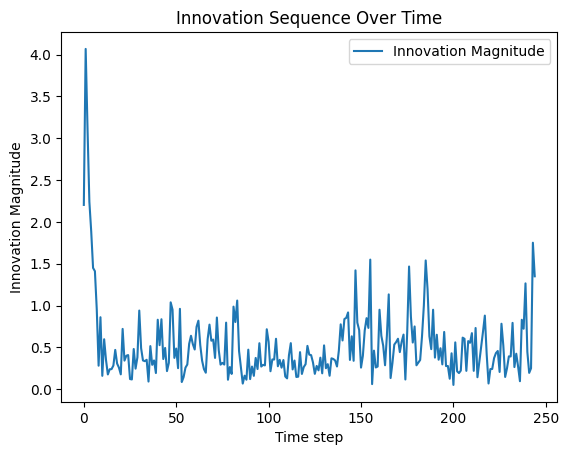

In [15]:
# Plot innovation sequence
plot_innovation(innovations)

#### Task 3: Count Vehicular Traffic

In [16]:
video_path = "video_traffic.mp4"
vs = cv2.VideoCapture(video_path)

# Load YOLO model
net = cv2.dnn.readNet("yolov4-csp.weights", "yolov4-csp.cfg")
ln = net.getUnconnectedOutLayersNames()

detections = []

while True:
    grabbed, frame = vs.read()
    if not grabbed:
        break

    (H, W) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > 0.5:  # Detection threshold
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                detections.append((x, y, width, height))

vs.release()

In [17]:
from filterpy.kalman import KalmanFilter

def track_vehicle(video_path, detections):
    kf = KalmanFilter(dim_x=4, dim_z=2)  # 4D state (x, y, vx, vy) and 2D measurement (x, y)
    kf.x = np.array([0, 0, 0, 0])  # Initial state
    kf.F = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]])  # Transition
    kf.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])  # Measurement function
    kf.P *= 1000  # Covariance
    kf.R = np.eye(2) * 5  # Measurement noise
    kf.Q = np.eye(4) * 0.01  # Process noise

    innovations = []
    
    for bbox in detections:
        x, y, w, h = bbox
        measurement = np.array([x + w / 2, y + h / 2])
        
        kf.predict()
        kf.update(measurement)

        innovation = np.linalg.norm(measurement - kf.x[:2])
        innovations.append(innovation)
    
    return innovations

innovations = track_vehicle("video_traffic.mp4", detections)

In [18]:
def count_vehicles(detections, video_path):
    count_left = 0
    count_right = 0
    
    for bbox in detections:
        x, y, w, h = bbox
        if x < 640:  # Assuming left side of video frame is 1280px wide
            count_left += 1
        else:
            count_right += 1

    print(f"Vehicles moving left: {count_left}")
    print(f"Vehicles moving right: {count_right}")

count_vehicles(detections, "new_video.mp4")

Vehicles moving left: 463
Vehicles moving right: 373
